In [1]:
# resources
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769
# https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titaniccleaningfeatureengineering/testC.csv
/kaggle/input/titaniccleaningfeatureengineering/__results__.html
/kaggle/input/titaniccleaningfeatureengineering/trainC.csv
/kaggle/input/titaniccleaningfeatureengineering/__notebook__.ipynb
/kaggle/input/titaniccleaningfeatureengineering/custom.css
/kaggle/input/titaniccleaningfeatureengineering/__output__.json
/kaggle/input/titaniccleaningfeatureengineering/__results___files/__results___13_0.png


In [3]:
train = pd.read_csv('../input/titaniccleaningfeatureengineering/trainC.csv')
test = pd.read_csv('../input/titaniccleaningfeatureengineering/testC.csv')
submission = pd.read_csv('../input/titanic/gender_submission.csv')

In [4]:
#SVMs picky about data, scaling recommended to decrease training time (esp. with poly)
sc = MinMaxScaler()
X = sc.fit_transform(train[train.columns[1:]])
scaled_test = sc.fit_transform(test)
y = train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
# SVM - baseline
svm = SVC()
svm.fit(X_train,y_train)
prediction = svm.predict(X_test)
print('Accuracy for baseline SVM is ',metrics.accuracy_score(prediction,y_test))

Accuracy for baseline SVM is  0.9273743016759777


In [6]:
submission['Survived'] = svm.predict(scaled_test)
submission.to_csv("submission.csv", index = False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


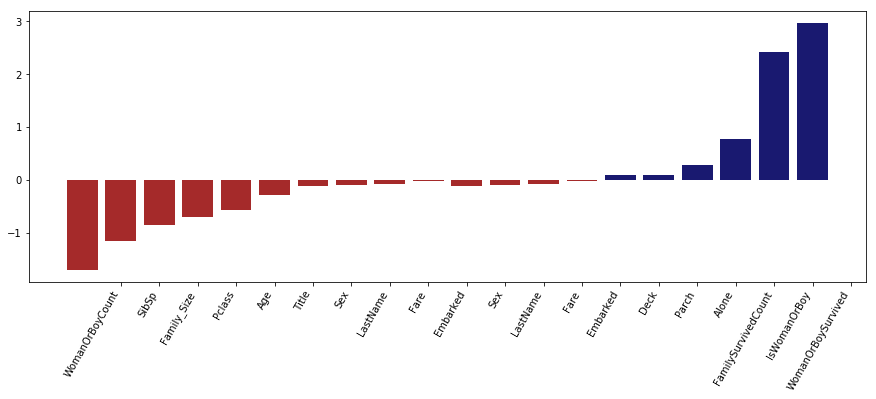

In [7]:
# Visualising Top Features 
# the plot provides useful insight into what features (words) are being used by the model to make the positive and negative classifications from a sentiment dataset

def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    plt.figure(figsize=(15, 5))
    colors = ['brown' if c < 0 else 'midnightblue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    

feature_names = list(test.columns.values)

svm = SVC(kernel='linear')
svm.fit(X_train,y_train)
plot_coefficients(svm, feature_names)

In [8]:
# Kernel
# kernel parameter selects the type of hyperplane used to separate the data

kernels = ['linear', 'rbf', 'poly']

for kernel in kernels:
    svm = SVC(kernel=kernel)
    svm.fit(X_train,y_train)
    prediction = svm.predict(X_test)
    print(kernel, ':   ',metrics.accuracy_score(prediction,y_test))

linear :    0.9217877094972067
rbf :    0.9273743016759777
poly :    0.8994413407821229


In [9]:
# gamma
#  parameter for non linear hyperplanes (the higher the gamma value the more the SVM tries to exactly fit the training data set)

gammas = [0.01, 0.1, 1, 10, 100]

for gamma in gammas:
    svm = SVC(gamma=gamma)
    svm.fit(X_train,y_train)
    prediction = svm.predict(X_test)
    print(gamma, ': ', metrics.accuracy_score(prediction,y_test))

0.01 :  0.8994413407821229
0.1 :  0.9273743016759777
1 :  0.9329608938547486
10 :  0.888268156424581
100 :  0.770949720670391


In [10]:
# C
# penalty parameter of the error term (controls the trade off between smooth decision boundary and classifying the training points correctly)

cs = [0.1, 1, 10, 100, 1000]

for c in cs:
    svm = SVC(C=c)
    svm.fit(X_train,y_train)
    prediction = svm.predict(X_test)
    print(c, ': ', metrics.accuracy_score(prediction,y_test))

0.1 :  0.8994413407821229
1 :  0.9273743016759777
10 :  0.9329608938547486
100 :  0.9217877094972067
1000 :  0.9217877094972067


In [11]:
# degree
# parameter for ‘poly’ kernel (the degree of the polynomial used to find the hyperplane to split the data)
# using degree=1 is the same as using a ‘linear’ kernel
# increasing this parameters leads to higher training times

degrees = [0, 1, 2, 3, 4, 5, 6]

for degree in degrees:
    svm = SVC(kernel='poly', degree=degree)
    svm.fit(X_train,y_train)
    prediction = svm.predict(X_test)
    print(degree, ': ', metrics.accuracy_score(prediction,y_test))

0 :  0.6145251396648045
1 :  0.8938547486033519
2 :  0.9050279329608939
3 :  0.8994413407821229
4 :  0.8994413407821229
5 :  0.6145251396648045
6 :  0.6145251396648045


In [12]:
kernels = ['linear', 'rbf', 'poly']
gammas = [0.01, 0.1, 1, 10, 100]
cs = [0.1, 1, 10, 100, 1000]

param = { 'kernel' : kernels, 
         'gamma' : gammas, 
         'C' : cs,
        }
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
grid = GridSearchCV(SVC(), param, cv=cv, verbose = False, n_jobs=-1)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.01, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=False)

In [13]:
print (grid.best_score_)
print (grid.best_params_)
print(grid.best_estimator_)

0.9421641791044776
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


In [14]:
submission['Survived'] = grid.predict(scaled_test)
submission.to_csv("submission_GridSearchCV.csv", index = False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
